In [1]:
import numpy as np
import pandas as pd
import cv2
from numpy import random, moveaxis
import os
import pyautogui
from win32api import GetSystemMetrics
import matplotlib.pyplot as plt

In [2]:
source = 'fer2013/sample_fer2013.csv'
sample = pd.read_csv(source)
print(sample.shape)
sample.head(20)

(13, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


9076
2304


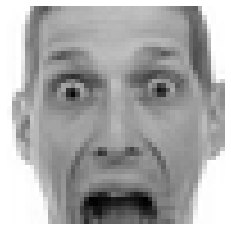

In [3]:
line = sample['pixels'][9]
print(len(line))
image_data = np.asarray([int(x) for x in line.split()])  # numpy array
print(len(image_data))
img = image_data.reshape((48,48)).astype('uint8')  # 2-d numpy array
# img = cv2.bitwise_not(img)  # w&b bitwise inverted or do not multiply by 255
    
# print(f'ID:{id} \n{clases[clase]}')
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

**New detections**

In [12]:
# face detector
protoPath = os.path.join('models', 'deploy.prototxt')
modelPath = os.path.join('models', 'res10_300x300_ssd_iter_140000.caffemodel')
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
threshold = 0.45  # to filter out week face detections
px_filter = 15  # size filter to ensure a sufficiently large face
divider = 300  # every 100 fps (iterations) we save and c comes back to zero and then to start the counting again

In [13]:
VID = os.path.join('media', 'plusfaces.avi')
webcam = cv2.VideoCapture(VID)
vectors = []  # pixels
emos = []  # emotion
Usage = []  # Usage

c = 1
while True:
    ret, frame = webcam.read()
    fps = webcam.get(cv2.CAP_PROP_POS_FRAMES)  # CAP_PROP_FS
    
    if ret is False:
        print('Ok. Finished')
        break
        
    if c%divider==0:  # c comes back to zero and then to start the counting again from 1
        
        frame = cv2.normalize(frame, None, 10, 245, cv2.NORM_MINMAX)
        (h_frame, w_frame) = frame.shape[:2]

        imageBlob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 187.0, 123.), swapRB=False, crop=False)
        detector.setInput(imageBlob)
        detections = detector.forward()

        for i in range(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]

            if confidence > threshold:
                box = detections[0, 0, i, 3:7] * np.array([w_frame, h_frame, w_frame, h_frame])
                (startX, startY, endX, endY) = box.astype("int")  # x, y coordinates of the bounding box for the face
                (startX, startY, endX, endY) = (6+startX, 6+startY, 6+endX, 6+endY)  # offset for classification

                face = frame[startY:endY, startX:endX]
                face = cv2.resize(face, (300, 300), interpolation=cv2.INTER_AREA)
                (fH, fW) = face.shape[:2]
                # n1 = os.path.join('fer2013', 'us', str(i)+'_'+str(fps)+'_color.jpg')
                # cv2.imwrite(n1, face)

                if fW < px_filter or fH < px_filter:
                    continue

                gray = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
                # cv2.imwrite('text2.jpg', gray)

                gray48 = cv2.resize(gray, (48, 48), interpolation=cv2.INTER_AREA)
                
                flat = np.array(gray48).flatten('C')  # vectorizing the image
                flat_str = ' '.join([str(elem) for elem in flat])  # convert the array vector to a string
                vectors.append(flat_str)
                emos.append('0')  # temporary emotion
                Usage.append('Training')  # all for training
                
                n2 = os.path.join('fer2013', 'us', 'z_'+str(i)+'_'+str(int(fps))+'.jpg')
                cv2.imwrite(n2, gray48)
    c+=1
            
webcam.release()
cv2.destroyAllWindows()

Ok. Finished


In [14]:
print(f'elements: {len(vectors)}')

elements: 61


In [15]:
print(len(vectors[0]))
# print(vectors[0])

8724


In [16]:
addon = {
    'emotion': emos,
    'pixels': vectors,
    'Usage': Usage,
}
addon_data = pd.DataFrame.from_dict(addon)
print(addon_data.shape[0])
addon_data.head(10)

61


,emotion,pixels,Usage
0,0,78 80 73 77 97 130 133 115 94 85 105 79 86 85 ...,Training
1,0,61 55 64 131 136 167 147 125 98 73 53 92 126 1...,Training
2,0,54 48 47 54 54 48 53 67 80 93 106 115 128 137 ...,Training
3,0,80 52 49 52 58 86 122 143 150 154 154 154 158 ...,Training
4,0,43 47 46 50 52 60 65 79 97 103 110 114 122 136...,Training
5,0,43 50 43 39 44 51 56 60 72 74 90 109 132 144 1...,Training
6,0,40 74 86 109 125 149 166 173 180 186 189 191 1...,Training
7,0,54 75 120 132 128 126 121 123 125 125 126 128 ...,Training
8,0,52 76 104 124 141 151 157 169 175 180 183 185 ...,Training
9,0,67 57 44 67 83 109 141 155 163 165 163 164 167...,Training


0


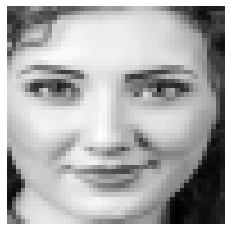

2
1


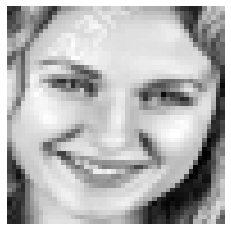

1
2


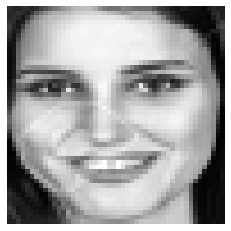

1
3


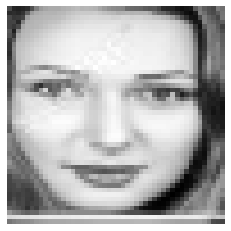

2
4


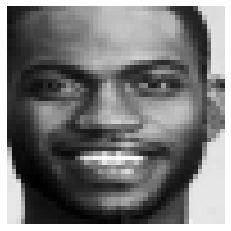

1
5


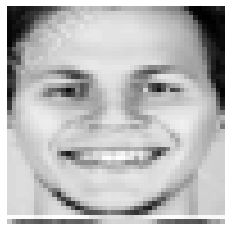

1
6


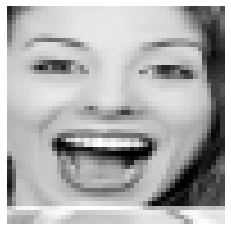

1
7


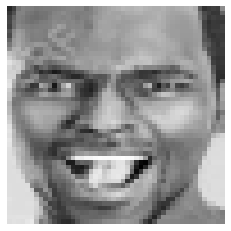

1
8


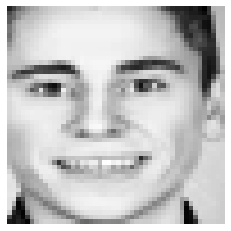

1
9


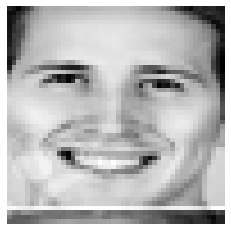

1
10


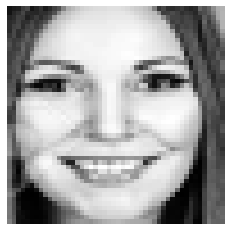

1
11


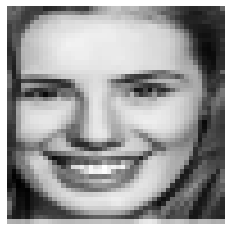

1
12


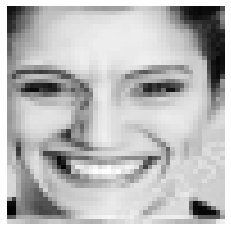

1
13


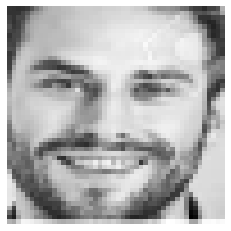

1
14


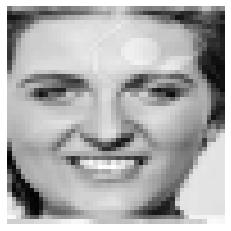

1
15


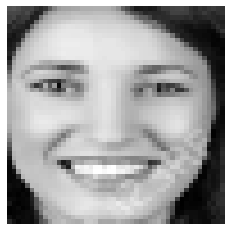

1
16


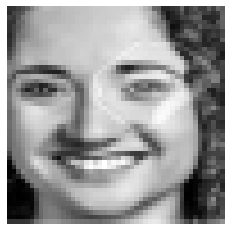

1
17


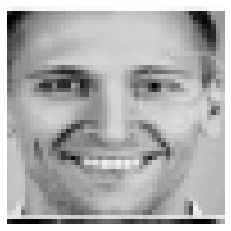

1
18


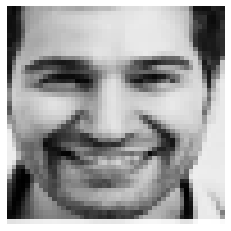

1
19


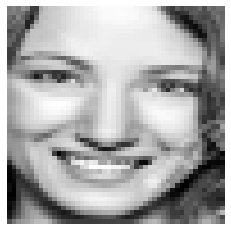

1
20


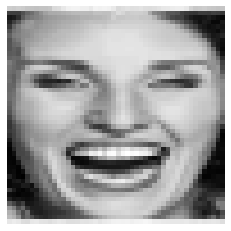

1
21


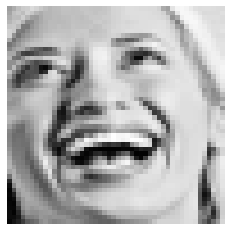

1
22


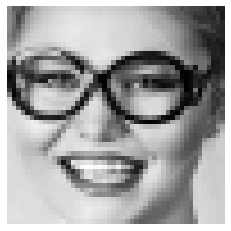

1
23


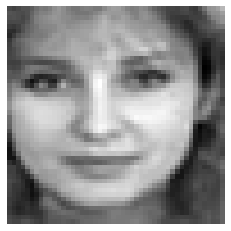

2
24


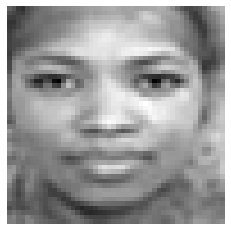

2
25


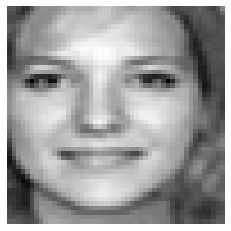

1
26


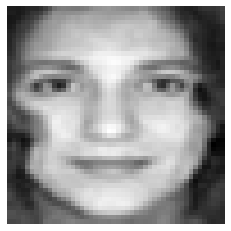

2
27


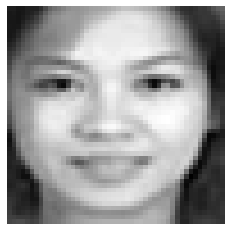

2
28


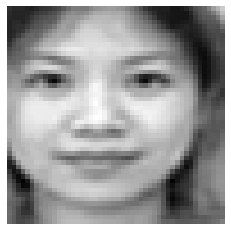

2
29


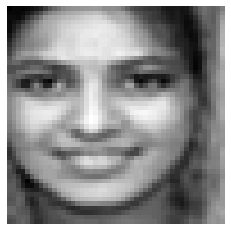

2
30


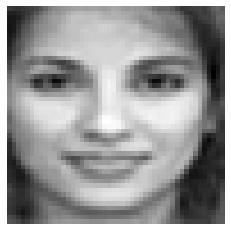

2
31


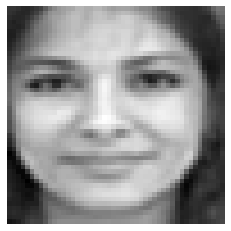

2
32


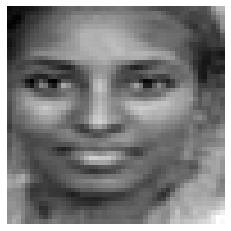

2
33


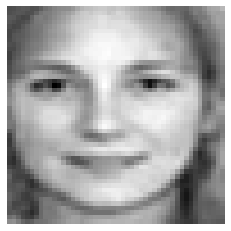

2
34


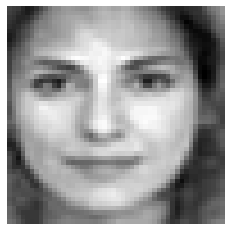

2
35


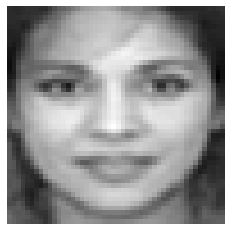

2
36


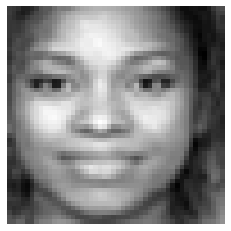

2
37


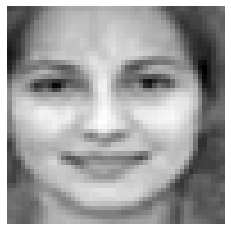

2
38


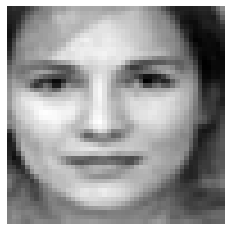

2
39


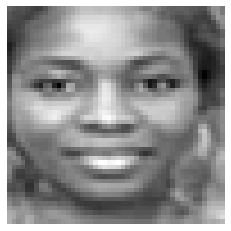

2
40


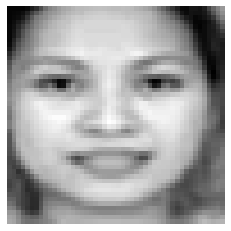

2
41


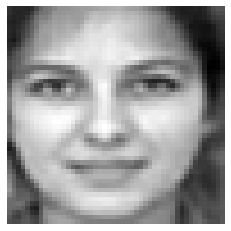

2
42


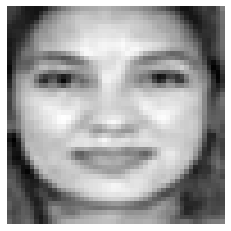


43


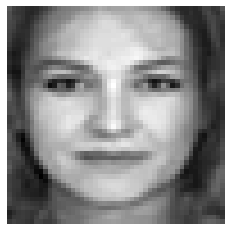

2
44


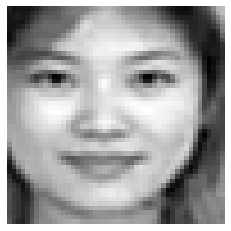

2
45


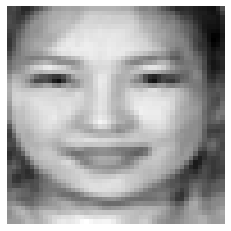

2
46


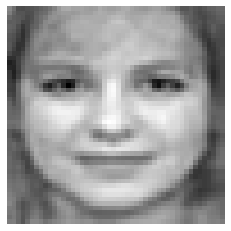

2
47


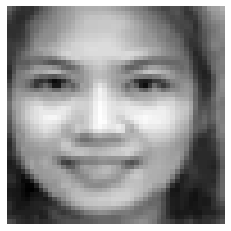

1
48


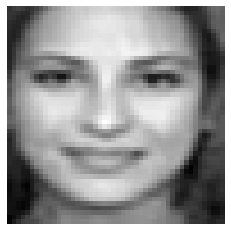

1
49


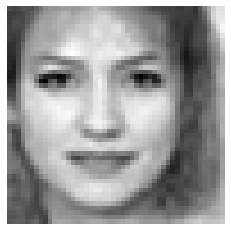

2
50


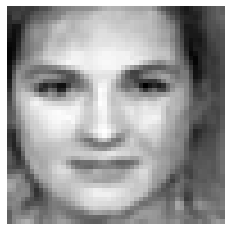

2
51


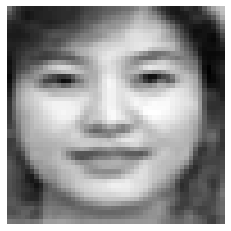

2
52


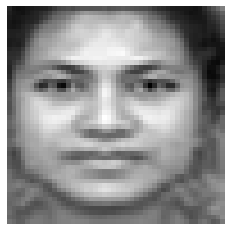

2
53


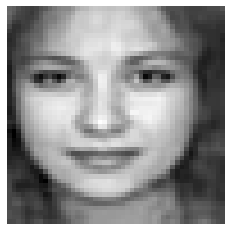

2
54


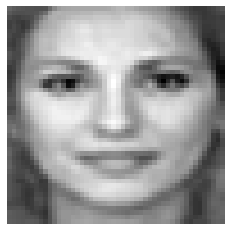

2
55


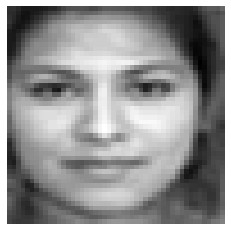

2
56


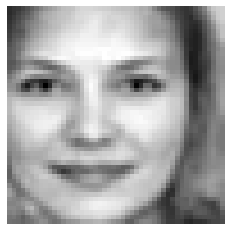

2
57


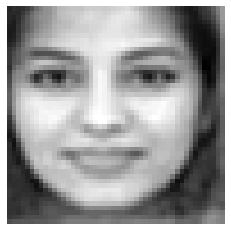

2
58


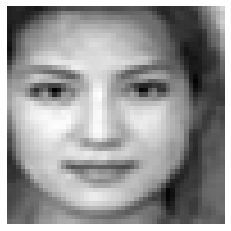

2
59


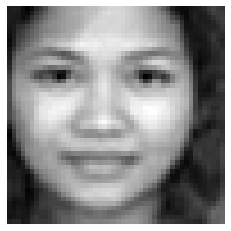

2
60


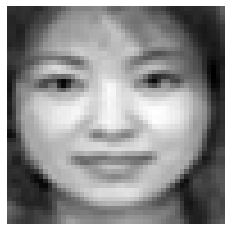

2


In [18]:
emotion_dict = {0: "upset", 1: "happy", 2: "neutral"}

for n in range(0, addon_data.shape[0]):
    print(n)
    lin = addon_data['pixels'][n]
    # print(len(lin))
    img_dt = np.asarray([int(x) for x in lin.split()])  # numpy array
    # print(len(img_dt))
    im = img_dt.reshape((48,48)).astype('uint8')  # 2-d numpy array
    # img = cv2.bitwise_not(img)  # w&b bitwise inverted or do not multiply by 255

    # print(f'ID:{id} \n{clases[clase]}')
    plt.imshow(im, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()
    a = input()
    addon_data.at[n, 'emotion'] = a

In [19]:
addon_data.head(20)

,emotion,pixels,Usage
0,2,78 80 73 77 97 130 133 115 94 85 105 79 86 85 ...,Training
1,1,61 55 64 131 136 167 147 125 98 73 53 92 126 1...,Training
2,1,54 48 47 54 54 48 53 67 80 93 106 115 128 137 ...,Training
3,2,80 52 49 52 58 86 122 143 150 154 154 154 158 ...,Training
4,1,43 47 46 50 52 60 65 79 97 103 110 114 122 136...,Training
5,1,43 50 43 39 44 51 56 60 72 74 90 109 132 144 1...,Training
6,1,40 74 86 109 125 149 166 173 180 186 189 191 1...,Training
7,1,54 75 120 132 128 126 121 123 125 125 126 128 ...,Training
8,1,52 76 104 124 141 151 157 169 175 180 183 185 ...,Training
9,1,67 57 44 67 83 109 141 155 163 165 163 164 167...,Training


In [20]:
addon_data['emotion'].unique()

array(['2', '1', ''], dtype=object)

In [21]:
Name_addon_data = 'fer2013\\fer2021_2.csv'
addon_data.to_csv(Name_addon_data, index=False)